## Importing Libraries

In [1]:
import os
import random
from PIL import Image
from pathlib import Path
from timeit import default_timer as Timer
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader, ConcatDataset, Dataset
from torchinfo import summary
import wandb
import onnx
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from Scripts import engine

print(torch.__version__)
print(torchvision.__version__)

c:\Users\YUVRAJ\ML\Projects_end-to-end\AI_image_classifier\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.6.0+cpu
0.21.0+cpu


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Downloading Data

In [3]:
import requests
import zipfile

data_path = Path("data/")
image_path = data_path / "CIFAKE"

if image_path.is_dir():
    print(f"{image_path} directory exists")
else:
    print(f"Creating {image_path} directory...")
    image_path.mkdir(parents= True, exist_ok= True)

    with open(data_path / "cifake-real-and-ai-generated-synthetic-images.zip", "wb") as f:
        request = requests.get("https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/cifake-real-and-ai-generated-synthetic-images.zip")
        print("Downloading data...")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "cifake-real-and-ai-generated-synthetic-images.zip", "r") as zip_ref:
        print("Unzipping  data...") 
        zip_ref.extractall(image_path)

    os.remove(data_path / "cifake-real-and-ai-generated-synthetic-images.zip")

data\CIFAKE directory exists


In [4]:
data_path = Path("data/")
image_path = data_path/"CIFAKE"

def walk_trough_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories & {len(filenames)} images in {dirpath}.")

walk_trough_dir(image_path)

There are 2 directories & 0 images in data\CIFAKE.
There are 2 directories & 0 images in data\CIFAKE\test.
There are 0 directories & 10000 images in data\CIFAKE\test\FAKE.
There are 0 directories & 10000 images in data\CIFAKE\test\REAL.
There are 2 directories & 0 images in data\CIFAKE\train.
There are 0 directories & 50000 images in data\CIFAKE\train\FAKE.
There are 0 directories & 50000 images in data\CIFAKE\train\REAL.


In [5]:
train_dir = image_path/"train"
test_dir = image_path/"test"
train_dir, test_dir

(WindowsPath('data/CIFAKE/train'), WindowsPath('data/CIFAKE/test'))

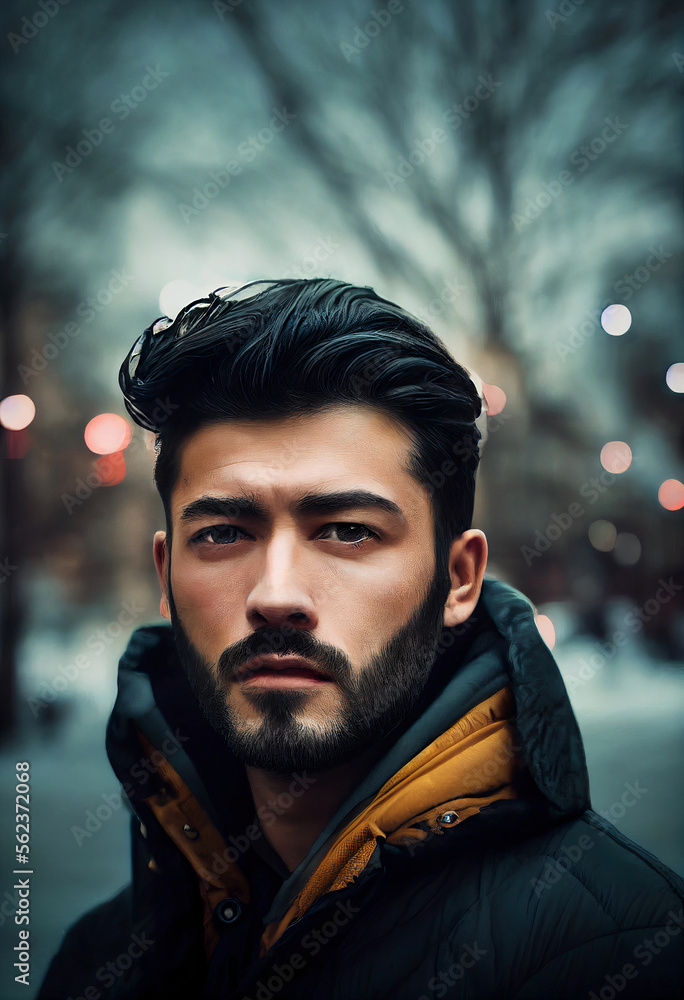

In [6]:
image_path_test = "man.jpg"
img_test = Image.open(image_path_test)
img_test

FAKE


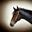

In [38]:
torch.manual_seed(42)

random_image_list = list(image_path.glob("*/*/*.jpg"))
random_img_path = random.choice(random_image_list)
image_class = random_img_path.parent.stem
random_img = Image.open(random_img_path)

print(image_class)
random_img

## Preprocessing Data

In [7]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop((224, 224), scale=(0.1,1)),
    transforms.ToTensor()
])

In [8]:
augmentation_transforms = {
    "No_Augmentation" : transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomResizedCrop((224,224), scale = (0.1, 1)),
        transforms.ToTensor()
    ]),
    "Gaussian_Blur" : transforms.Compose([
        transforms.RandomApply([
            transforms.GaussianBlur(kernel_size= 3, sigma= (0.1, 0.3))
        ], p= 0.5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
    ])
}

NameError: name 'image_class' is not defined

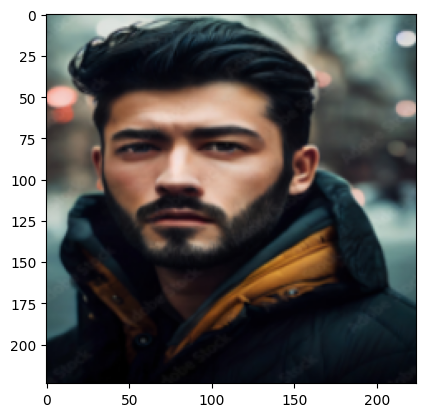

In [12]:
transformed_image_1 = transform(img_test)

plt.figure()
plt.imshow(transformed_image_1.permute(1,2,0))
plt.title(f"Image class : {image_class} & shape : {transformed_image_1.shape}")
plt.axis(False);

In [13]:
transformed_image_1 = transformed_image_1.unsqueeze(dim = 0).to(device)

In [9]:
class_names = ["FAKE", "REAL"]
class_dict = {"FAKE": 0,
              "REAL": 1}

In [30]:
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [31]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform= transform,
                                  target_transform= None)
test_data = datasets.ImageFolder(root = test_dir,
                                 transform= test_transform)

In [32]:
len(train_data), len(test_data)

(100000, 20000)

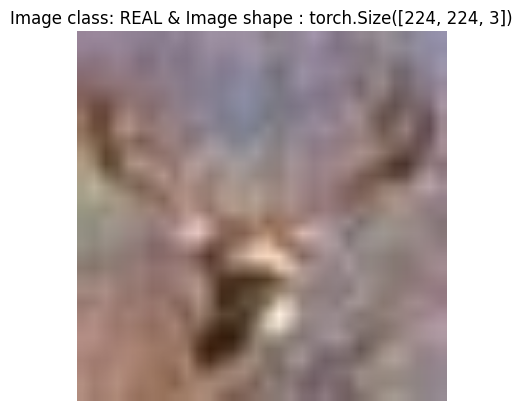

In [33]:
random_idx = random.randint(0, 20000)
plt.imshow(test_data[random_idx][0].permute(1,2,0))
plt.title(f"Image class: {class_names[test_data[random_idx][1]]} & Image shape : {test_data[random_idx][0].permute(1,2,0).shape}")
plt.axis(False);

In [34]:
def create_subset(dataset, num_of_datasets, size_of_datasets):
    """
    This will create n no. of subsets of the given data

    Args:
        dataset: The original dataset.
        num_subsets: Number of subsets to create.
        subset_size: Number of samples in each subset.
    
    Returns:
        A list of Subset objects.
    """
    subsets = []
    for i in range(num_of_datasets):
        start_idx = i * int(size_of_datasets / 2) 
        end_idx = start_idx + int(size_of_datasets / 2)

        start_idx_2 = start_idx + int(len(dataset) / 2)
        end_idx_2 = end_idx + int(len(dataset) / 2)

        subset_indices_1 = list(range(start_idx, end_idx))
        subset_indices_2 = list(range(start_idx_2, end_idx_2))
        subset_indices = subset_indices_1 + subset_indices_2
        random.shuffle(subset_indices)
        
        subsets.append(Subset(dataset, subset_indices))

    return subsets

In [35]:
train_subset = create_subset(train_data, 40, 2500)
test_subset = create_subset(test_data, 40, 500)

img, label = next(iter(test_subset[0]))
img

tensor([[[0.9725, 0.9725, 0.9725,  ..., 0.9569, 0.9569, 0.9569],
         [0.9725, 0.9725, 0.9725,  ..., 0.9569, 0.9569, 0.9569],
         [0.9725, 0.9725, 0.9725,  ..., 0.9569, 0.9569, 0.9569],
         ...,
         [0.5647, 0.5647, 0.5647,  ..., 0.7216, 0.7216, 0.7216],
         [0.5647, 0.5647, 0.5647,  ..., 0.7216, 0.7216, 0.7216],
         [0.5647, 0.5647, 0.5647,  ..., 0.7216, 0.7216, 0.7216]],

        [[0.9686, 0.9686, 0.9686,  ..., 0.9765, 0.9765, 0.9765],
         [0.9686, 0.9686, 0.9686,  ..., 0.9765, 0.9765, 0.9765],
         [0.9686, 0.9686, 0.9686,  ..., 0.9765, 0.9765, 0.9765],
         ...,
         [0.6118, 0.6118, 0.6118,  ..., 0.7529, 0.7529, 0.7529],
         [0.6118, 0.6118, 0.6118,  ..., 0.7529, 0.7529, 0.7529],
         [0.6118, 0.6118, 0.6118,  ..., 0.7529, 0.7529, 0.7529]],

        [[0.9882, 0.9882, 0.9882,  ..., 1.0000, 1.0000, 1.0000],
         [0.9882, 0.9882, 0.9882,  ..., 1.0000, 1.0000, 1.0000],
         [0.9882, 0.9882, 0.9882,  ..., 1.0000, 1.0000, 1.

In [36]:
len(train_subset), len(train_subset[0]),len(train_subset[0][0]), len(train_subset[0][0][0]), len(train_subset[0][0][0][0])

(40, 2500, 2, 3, 224)

In [37]:
BATCH_SIZE = 50

train_dataloader_subsets = [DataLoader(subset, BATCH_SIZE, shuffle= True) for subset in train_subset]
test_dataloader_subsets = [DataLoader(subset, BATCH_SIZE) for subset in test_subset]

train_dataloader_subsets[0]

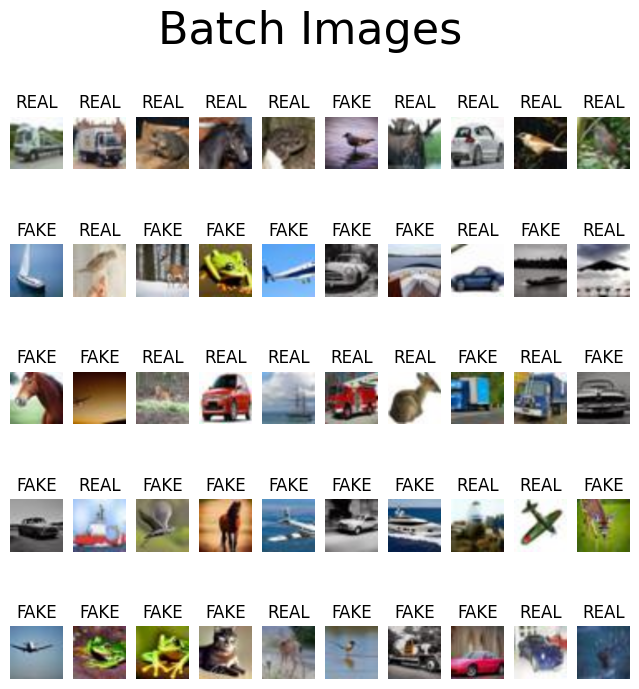

In [39]:
fig = plt.figure(figsize=(8,8))

fig.suptitle("Batch Images", fontsize=32)
rows, columns = 5, 10
for batch_idx, (img, label) in enumerate(test_dataloader_subsets[0]):
    if (batch_idx < 1):
        for i in range(1, rows * columns + 1):
            fig.add_subplot(rows, columns, i)
            plt.imshow(img[i-1].permute(1,2,0))
            plt.title(class_names[int(label[i-1])], fontsize=12)
            plt.axis(False);


## Model

In [114]:
model_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [117]:
transform = model_weights.transforms()
transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [104]:
effb7_model = torchvision.models.efficientnet_b7(weights= model_weights).to(device)
effb7_model

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to C:\Users\YUVRAJ/.cache\torch\hub\checkpoints\efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [10:47<00:00, 412kB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [105]:
summary(model= effb7_model,
        input_size= (25,3,224,224),
        col_names= ["input_size", "output_size","num_params", "trainable"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [25, 3, 224, 224]         [25, 1000]                --                        True
├─Sequential: 1-1                                       [25, 3, 224, 224]         [25, 2560, 7, 7]          --                        True
│    └─Conv2dNormActivation: 2-1                        [25, 3, 224, 224]         [25, 64, 112, 112]        --                        True
│    │    └─Conv2d: 3-1                                 [25, 3, 224, 224]         [25, 64, 112, 112]        1,728                     True
│    │    └─BatchNorm2d: 3-2                            [25, 64, 112, 112]        [25, 64, 112, 112]        128                       True
│    │    └─SiLU: 3-3                                   [25, 64, 112, 112]        [25, 64, 112, 112]        --                        --
│    └─Sequential: 2-2  

In [106]:
effb7_model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=2560, out_features=1000, bias=True)
)

In [93]:
for parameter in vit_model.parameters():
    parameter.requires_grad = False

vit_model.heads = nn.Sequential(
    nn.Linear(in_features=768, out_features= 2, bias= True)
)

summary(model= vit_model,
        input_size= (25,3,224,224),
        col_names= ["input_size", "output_size","num_params", "trainable"])

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Trainable
VisionTransformer                             [25, 3, 224, 224]         [25, 2]                   768                       Partial
├─Conv2d: 1-1                                 [25, 3, 224, 224]         [25, 768, 14, 14]         (590,592)                 False
├─Encoder: 1-2                                [25, 197, 768]            [25, 197, 768]            151,296                   False
│    └─Dropout: 2-1                           [25, 197, 768]            [25, 197, 768]            --                        --
│    └─Sequential: 2-2                        [25, 197, 768]            [25, 197, 768]            --                        False
│    │    └─EncoderBlock: 3-1                 [25, 197, 768]            [25, 197, 768]            (7,087,872)               False
│    │    └─EncoderBlock: 3-2                 [25, 197, 768]            [25, 197, 768] 

In [94]:
class empty_dataset(Dataset):

    def __init__(self):
        pass

    def __len__(self):
        return 0
    
    def __getitem__(self, idx):
        return IndexError("This dataset is empty!")

In [95]:
def amount_of_data(dataloader_subsets,
                   multiple,
                   batch_size):
    total_subsets = len(dataloader_subsets)

    concatdataset = empty_dataset()
    
    if multiple > total_subsets:
        raise ValueError(
            "multiple greater than the number of subsets"
        )
    else:
        for i in range(multiple):
            dataloader_dataset = dataloader_subsets[i].dataset
            concatdataset = ConcatDataset([concatdataset, dataloader_dataset])
        dataloaders = DataLoader(concatdataset, batch_size= batch_size, shuffle= True)
        
    return dataloaders

In [50]:
subset_2_dataloader = amount_of_data(test_dataloader_subsets, 2, 50)
len(subset_2_dataloader)

20

## Training

In [51]:
optimizer = torch.optim.Adam([
        {"params": efficientb0_model.classifier.parameters(), "lr" : 0.01},
        {"params": efficientb0_model.features[-2:].parameters(), "lr" : 0.001}
    ], weight_decay= 1e-4)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.0001

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)

In [ ]:
with wandb.init(project="AI_Image_Classification", name="50_0.01-0.001_10_subs_2_last_3_layer_unfreeze", settings=wandb.Settings(symlink=False)) as run:
    learning_rate_classifier = 0.01
    learning_rate_unfrozenlayer = 0.001
    batch_size = 50
    epochs = 10
    subsetdata_amount = 2

    run.config.learning_rate = learning_rate_classifier
    run.config.learning_rate_unfrozenlayer = learning_rate_unfrozenlayer
    run.config.batch_size = batch_size
    run.config.epochs = epochs
    run.config.subsetdata_amount = subsetdata_amount
    run.config.ARCHITECHTURE = "EfficientNet_B0_unfreezed_last_3_layer"

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam([
        {"params": efficientb0_model.classifier.parameters(), "lr" : learning_rate_classifier},
        {"params": efficientb0_model.features[-2:].parameters(), "lr" : learning_rate_unfrozenlayer}
    ], weight_decay= 1e-4)

    results = { 
            "train loss": [],
            "train acc": [],
            "test loss": [],
            "test acc": []
        }
    
    train_subsetdata_amount_dataloader = amount_of_data(train_dataloader_subsets, subsetdata_amount, batch_size)
    test_subsetdata_amount_dataloader = amount_of_data(test_dataloader_subsets, subsetdata_amount, batch_size)

    for epoch in tqdm(range(epochs)):

        # Training Loop
        train_loss, train_acc, y_train_actual, y_train_predicted = engine.train_loop(model= efficientb0_model,
                                                                                     train_dataloader= train_subsetdata_amount_dataloader,
                                                                                     loss_fn= loss_fn,
                                                                                     optimizer= optimizer,
                                                                                     device= device)
        

        # Testing Loop
        test_loss, test_acc, y_test_actual, y_test_predicted = engine.test_loop(model= efficientb0_model,
                                                                                test_dataloader= test_subsetdata_amount_dataloader,
                                                                                loss_fn= loss_fn,
                                                                                device= device)

        results["train loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

        run.log({
            "epoch" : epoch + 1,
            "train_loss" : train_loss,
            "train_accuracy" : train_acc,
            "test_loss" : test_loss,
            "test_accuracy" : test_acc,
        })

        print(f"Epoch {epoch + 1}/{epochs}: train loss: {train_loss:.4f} |\ntrain accuracy: {train_acc:.4f} |\ntest loss: {test_loss:.4f} |\ntest accuracy: {test_acc:.4f}")

        torch.onnx.export(
            efficientb0_model,
            torch.randn(1,3,224,224),
            "Models\model.onnx",
            input_names = ["input"],
            output_names = ["output"],
        )
    
    run.log_artifact("Models\model.onnx", name= "50_0.01-0.001_10_subs_2_last_3_layer_unfreeze", type= "model")

    print("Model training completed.")

## Metrics

In [30]:
classification_report(y_train_actual, y_train_predicted)

NameError: name 'y_train_actual' is not defined

In [52]:
classification_report(y_test_actual, y_test_predicted)

'              precision    recall  f1-score   support\n\n           0       0.86      0.86      0.86      1000\n           1       0.86      0.86      0.86      1000\n\n    accuracy                           0.86      2000\n   macro avg       0.86      0.86      0.86      2000\nweighted avg       0.86      0.86      0.86      2000\n'

In [ ]:
cm = confusion_matrix(y_train_actual, y_train_predicted)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot();

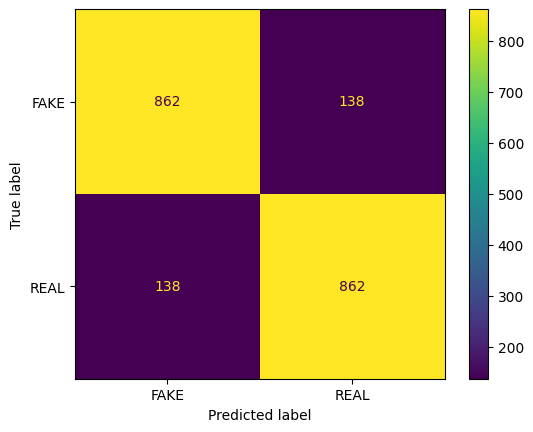

In [53]:
cm_test = confusion_matrix(y_test_actual, y_test_predicted)
disp = ConfusionMatrixDisplay(cm_test, display_labels= class_names)
disp.plot();

## Inference

In [10]:
onnx_model = onnx.load("Models/100_percentdata.onnx")

onnx.checker.check_model(onnx_model)
print("ONNX model loaded and verified successfully!")

ONNX model loaded and verified successfully!


In [7]:
from Scripts import datapreprocess

preprocess = datapreprocess.DataPreprocessor(train_dir= train_dir,
                                             test_dir= test_dir)

train_dataloader, test_dataloader = preprocess.Build_Dataloaders(percentage_data= 10)
test_dataloader

In [8]:
loss_fn = torch.nn.CrossEntropyLoss()

In [9]:
import onnxruntime as ort
import numpy as np

batch_size = 50

ort_session = ort.InferenceSession("Models/100_percentdata.onnx")
input_name = ort_session.get_inputs()[0].name

test_loss, test_acc = 0.0, 0.0
y_test_actual = []
y_test_predicted = []

with torch.inference_mode():
    for batch_idx, (x, y) in enumerate(test_dataloader):
        x, y = x.to(device), y.to(device)

        batch_predictions = []
        for i in range(x.shape[0]):
            single_input = x[i].unsqueeze(0).cpu().numpy()
            
            outputs = ort_session.run(None, {input_name: single_input})
            batch_predictions.append(outputs[0])
        
        y_pred = torch.from_numpy(np.concatenate(batch_predictions)).to(device)

        loss = loss_fn(y_pred, y)
        test_loss += loss.item()

        y_class_pred = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        test_acc += (y_class_pred == y).sum().item() / len(y_pred)

        y_test_predicted.extend(y_class_pred.cpu().numpy())
        y_test_actual.extend(y.cpu().numpy())

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Test Loss: 0.2527 | Test Acc: 0.8990


In [10]:
classification_report(y_test_actual, y_test_predicted)

'              precision    recall  f1-score   support\n\n           0       0.89      0.91      0.90      1000\n           1       0.91      0.89      0.90      1000\n\n    accuracy                           0.90      2000\n   macro avg       0.90      0.90      0.90      2000\nweighted avg       0.90      0.90      0.90      2000\n'

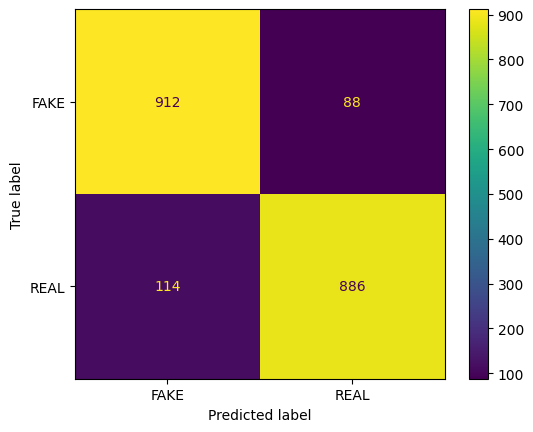

In [11]:
cm_test = confusion_matrix(y_test_actual, y_test_predicted)
disp = ConfusionMatrixDisplay(cm_test, display_labels= class_names)
disp.plot();

## GradCam Implementation

In [11]:
import onnx2torch
onnx_model = onnx.load("Models/100_percentdata.onnx")
pytorch_model = onnx2torch.convert(onnx_model)
pytorch_model

GraphModule(
  (features/features/0/features/0/0/Conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (features/features/0/features/0/2/Sigmoid): Sigmoid()
  (features/features/0/features/0/2/Mul): OnnxBinaryMathOperation()
  (features/features/1/features/1/0/block/block/0/block/0/0/Conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
  (features/features/1/features/1/0/block/block/0/block/0/2/Sigmoid): Sigmoid()
  (features/features/1/features/1/0/block/block/0/block/0/2/Mul): OnnxBinaryMathOperation()
  (features/features/1/features/1/0/block/block/1/avgpool/GlobalAveragePool): OnnxGlobalAveragePoolWithKnownInputShape()
  (features/features/1/features/1/0/block/block/1/fc1/Conv): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
  (features/features/1/features/1/0/block/block/1/activation/Sigmoid): Sigmoid()
  (features/features/1/features/1/0/block/block/1/activation/Mul): OnnxBinaryMathOperation()
  (features/features/1/features/1/

In [14]:
import onnxruntime as ort
import numpy as np

x = transformed_image_1

out_torch = pytorch_model(x)

ort_sess = ort.InferenceSession("Models/100_percentdata.onnx")
out_ort = ort_sess.run(None, {"input": x.numpy()})

class_names[np.argmax(out_torch.detach().numpy())], class_names[np.argmax(out_ort)]

('REAL', 'REAL')

In [15]:
layer_name = "features/features/8/features/8/0/Conv"
target_layer = getattr(pytorch_model, layer_name)
target_layer

Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1))

In [16]:
from pytorch_grad_cam import GradCAM
cam = GradCAM(pytorch_model, target_layers = [target_layer])

heatmap = cam(transformed_image_1)

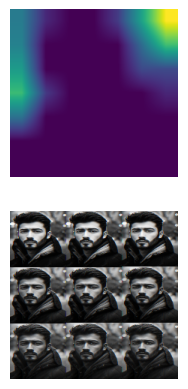

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2)
ax[0].imshow(heatmap.reshape(224,224,1))
ax[0].axis(False);
ax[1].imshow(transformed_image_1.reshape(224,224,3))
ax[1].axis(False);

In [114]:
transformed_image_1.squeeze(dim=0).shape

torch.Size([3, 224, 224])

In [113]:
heatmap.shape

(1, 224, 224)

In [20]:
og_image = transform(img_test)

In [22]:
og_image = og_image.numpy()

In [21]:
from pytorch_grad_cam import GradCAM
cam = GradCAM(pytorch_model, target_layers= [target_layer])
heatmap = cam(og_image.unsqueeze(dim=0).to(device))
heatmap

array([[[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        ...,
        [0.       , 0.       , 0.       , ..., 0.3804767, 0.3804767,
         0.3804767],
        [0.       , 0.       , 0.       , ..., 0.3804767, 0.3804767,
         0.3804767],
        [0.       , 0.       , 0.       , ..., 0.3804767, 0.3804767,
         0.3804767]]], shape=(1, 224, 224), dtype=float32)

In [23]:
og_image_hwc = np.transpose(og_image,(1,2,0))
heatmap_hwc = np.transpose(heatmap, (1,2,0))
heatmap_2d = heatmap_hwc[:, :, 0]

In [24]:
import cv2

heatmap_norm = (heatmap_2d - heatmap_2d.min())/(heatmap_2d.max() - heatmap_2d.min())
heatmap_uint8 = np.uint8(heatmap_norm * 255)

heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
heatmap_color = cv2.applyColorMap(heatmap_color, cv2.COLOR_BGR2RGB)

if og_image_hwc.max() <= 1.0:
    img_rgb_uint8 = np.uint8(255 * og_image_hwc)
else:
    img_rgb_uint8 = og_image_hwc.astype

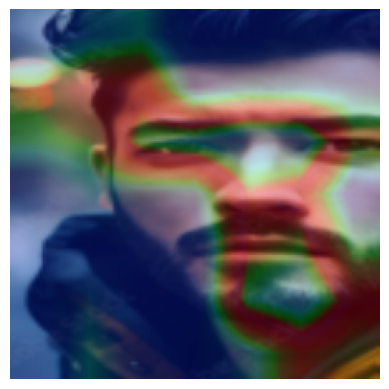

In [25]:
alpha = 0.25

overlay = cv2.addWeighted(img_rgb_uint8, 1 - alpha, heatmap_color, alpha, 0)

plt.imshow(overlay)
plt.axis('off')
plt.show()

In [ ]:
import ollama
from io import BytesIO
import base64

client = ollama.Client()

overlay_uint8 = (overlay * 255).astype(np.uint8)
pil_image = Image.fromarray(overlay_uint8)

buffered = BytesIO()
pil_image.save(buffered, format="JPEG")
base64_image = base64.b64encode(buffered.getvalue()).decode("utf-8")

model = "bakllava"
prompt =  """
Analyze the image which contains an heatmap overlayed on original image, the heatmap is generated from the Deep Learning model which predicted the image to be AI generated. 
So explain why it's synthetic. Focus on:
1. Unnatural Blending (e.g., artificial transitions between objects/background)
2. Anatomical Inconsistencies (e.g., distorted proportions)
3. Color Treatment (e.g., uniform colors lacking natural variation)
4. Resolution/Detail (e.g., missing fine textures)
5. Motion Effects (e.g., unrealistic blur)

Format your answer as bullet points starting with the category name, like:
- Unnatural Blending: [explanation]
- Anatomical Inconsistencies: [explanation]
"""

response = client.generate(model= model, prompt= prompt, images= [base64_image], stream = False)

print("Response from ollama: ")
print(response)

In [27]:
response["response"]

"\nThe image is a Deep Learning generated picture of a man's face. The AI model used to generate this image predicted the original image to be a man's face, and as a result, the synthetic nature of the image can be quite evident. Analyzing the heatmap overlay, one can observe that the AI model made numerous mistakes while attempting to recreate the original photo, leading to an overall unnatural appearance of the face and its surroundings."